<a href="https://colab.research.google.com/github/franlopez1234/7506R-1C2023-GRUPO17/blob/main/7506R_TP1_GRUPO17_CHPX_ENTREGA_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Librerias

In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn import tree
from sklearn.compose import make_column_transformer
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, precision_score,
                             recall_score, make_scorer)

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, KFold, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
import seaborn as sns
import sklearn as sk
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

##Realizamos el tratamiento de las variables

In [ ]:
df_hotels_train = pd.read_csv('hotels_train.csv')

In [ ]:
df_hotels_train.head(2)

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,id,is_canceled
0,City Hotel,49,2016,September,37,5,1,2,1,0.0,...,NaN,0,Transient,115.5,0,1,Canceled,2016-08-25,7aa4cc6b-b92c-4061-b21d-4f9e0cac4689,1
1,Resort Hotel,4,2015,October,44,31,0,1,2,0.0,...,NaN,0,Transient,42.0,1,0,Check-Out,2015-11-01,b1428f80-c56c-4ae4-91a9-6962edae08b1,0


In [ ]:
#Eliminamos las columnas de reservation_status y reservation_status_date para evitar confusiones
df_hotels_train = df_hotels_train.drop(['reservation_status','reservation_status_date'], axis =1) #->Desmarcar al abrir el archivo
df_hotels_train.dtypes

hotel                              object
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             float64
company                           

In [ ]:
df_hotels_train['hotel'] = df_hotels_train['hotel'].astype('string')
df_hotels_train['arrival_date_month'] = df_hotels_train['arrival_date_month'].astype('string')
df_hotels_train['meal'] = df_hotels_train['meal'].astype('string')
df_hotels_train['country'] = df_hotels_train['country'].astype('string')
df_hotels_train['id'] = df_hotels_train['id'].astype('string')
df_hotels_train['customer_type'] = df_hotels_train['customer_type'].astype('string')
df_hotels_train['market_segment'] = df_hotels_train['market_segment'].astype('string')
df_hotels_train['distribution_channel'] = df_hotels_train['distribution_channel'].astype('string')
df_hotels_train['reserved_room_type'] = df_hotels_train['reserved_room_type'].astype('string')
df_hotels_train['assigned_room_type'] = df_hotels_train['assigned_room_type'].astype('string')
df_hotels_train['deposit_type'] = df_hotels_train['deposit_type'].astype('string')

Retiramos los nulos

In [ ]:
#Company
df_hotels_train['company'].fillna(-9999, inplace=True)

In [ ]:
#Agent
df_hotels_train['agent'].fillna(-9999, inplace=True)

In [ ]:
#Country
df_hotels_train['country'].fillna('PRT', inplace=True)

In [ ]:
#Children
df_hotels_train['children'].fillna(0, inplace=True)

Analizamos los outliers

In [ ]:
#columnas:(lead_time, stays_in_weekend_nights, stays_in_week_nights, adults, children, babies, previous_cancellations, previous_bookings_not_canceled, booking_changes, days_in_waiting_list, required_car_parking_spaces)
media_lead_time=np.mean(df_hotels_train.lead_time)
std_lead_time=np.std(df_hotels_train.lead_time)
df_zscore = pd.DataFrame()
df_zscore['z_lead_time']=(df_hotels_train.lead_time - media_lead_time)/std_lead_time
df_zscore[df_zscore['z_lead_time']>3]


,z_lead_time
15,3.186066
51,3.402834
95,3.086713
426,3.691859
576,4.640223
...,...
61579,3.655731
61695,3.213162
61761,3.466059
61783,3.086713


In [ ]:
for i in range(len(df_zscore['z_lead_time'])):
  if df_zscore.z_lead_time[i] > 3:
    df_hotels_train.lead_time[i] = round(media_lead_time)

/var/folders/2g/pz89x6gd4_z44j2mr8rthvmh0000gn/T/ipykernel_2604/3445656125.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hotels_train.lead_time[i] = round(media_lead_time)


In [ ]:
#Normalizamos previus cancellation
for i in range(len(df_hotels_train.previous_cancellations)):
  if df_hotels_train.previous_cancellations[i] > 10:
    df_hotels_train.previous_cancellations[i] = 0 #Redondeamos a 0 ya que no tiene sentido normilazarlos sacando una media

/var/folders/2g/pz89x6gd4_z44j2mr8rthvmh0000gn/T/ipykernel_2604/1879383880.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hotels_train.previous_cancellations[i] = 0 #Redondeamos a 0 ya que no tiene sentido normilazarlos sacando una media


In [ ]:
media_previous_bookings_not_canceled=np.mean(df_hotels_train.previous_bookings_not_canceled)
for i in range(len(df_hotels_train.previous_bookings_not_canceled)):
  if df_hotels_train.previous_bookings_not_canceled[i] > 30:
    df_hotels_train.previous_bookings_not_canceled[i] = round(media_previous_bookings_not_canceled)

/var/folders/2g/pz89x6gd4_z44j2mr8rthvmh0000gn/T/ipykernel_2604/3966743444.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hotels_train.previous_bookings_not_canceled[i] = round(media_previous_bookings_not_canceled)


In [ ]:
#Normalizamos los valores atipicos de booking change
for i in range(len(df_hotels_train.booking_changes)):
  if df_hotels_train.booking_changes[i] > 10:
    df_hotels_train.booking_changes[i] = 0 #Redondeamos a 0 ya que no tiene sentido normilazarlos sacando una media

/var/folders/2g/pz89x6gd4_z44j2mr8rthvmh0000gn/T/ipykernel_2604/3893981792.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hotels_train.booking_changes[i] = 0 #Redondeamos a 0 ya que no tiene sentido normilazarlos sacando una media


In [ ]:
media_days_in_waiting_list = np.mean(df_hotels_train.days_in_waiting_list)

for i in range(len(df_hotels_train.days_in_waiting_list)):
  if df_hotels_train.days_in_waiting_list[i] > 100:
    df_hotels_train.days_in_waiting_list[i] = round(media_days_in_waiting_list)

/var/folders/2g/pz89x6gd4_z44j2mr8rthvmh0000gn/T/ipykernel_2604/3411085939.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hotels_train.days_in_waiting_list[i] = round(media_days_in_waiting_list)


In [ ]:
media_required_car_parking_spaces = np.mean(df_hotels_train.required_car_parking_spaces)

for i in range(len(df_hotels_train.required_car_parking_spaces)):
  if df_hotels_train.required_car_parking_spaces[i] > 7:
    df_hotels_train.required_car_parking_spaces[i] = round(media_required_car_parking_spaces)

/var/folders/2g/pz89x6gd4_z44j2mr8rthvmh0000gn/T/ipykernel_2604/2146687091.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hotels_train.required_car_parking_spaces[i] = round(media_required_car_parking_spaces)


In [ ]:

df_hotels_train.reset_index(drop=True, inplace=True)
for i in range(len(df_hotels_train)):
  if df_hotels_train.adults[i] == 0:
    df_hotels_train = df_hotels_train.drop(index = [i])

df_hotels_train.reset_index(drop=True, inplace=True)

In [ ]:
df_hotels_train.reset_index(drop=True, inplace=True)
for i in range(len(df_hotels_train)):
  if df_hotels_train.adults[i] <= 2 and df_hotels_train.babies[i] >= 8:
    df_hotels_train = df_hotels_train.drop(index = [i])
    

df_hotels_train.reset_index(drop=True, inplace=True)

In [ ]:
media_adults=np.mean(df_hotels_train.adults)

for i in range(len(df_hotels_train)):
  if df_hotels_train.adults[i] >= 25:
    df_hotels_train.adults[i] = round(media_adults)

/var/folders/2g/pz89x6gd4_z44j2mr8rthvmh0000gn/T/ipykernel_2604/842624944.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hotels_train.adults[i] = round(media_adults)


In [ ]:
df_hotels_train.reset_index(drop=True, inplace=True)

for i in range(len(df_hotels_train)):
  if df_hotels_train.stays_in_week_nights[i] == 0 and df_hotels_train.stays_in_weekend_nights[i] == 0:
    df_hotels_train = df_hotels_train.drop(index = [i])

df_hotels_train.reset_index(drop=True, inplace=True)

Eliminamos id (recordar que la vamos a necesitar mas tarde)

In [ ]:
eliminar_columnas = ['id'] # -> Recordar que el id lo vamos a necesitar para machear en kaggle
                                                                      
df_hotels_train.drop(eliminar_columnas, axis='columns', inplace=True)

## Realizamos un encode de las variables

In [ ]:
# Realizamos el one hot encoding, con scikit learn.
# Por cada columna a encodear, hacer un fit transform. Dropear la columna, y agregar las columnas nuevas con el nombre adecuado
df_hotels_train_to_encode = df_hotels_train.copy()
cols_a_encodear = ['hotel','arrival_date_month','customer_type','meal', 'distribution_channel','market_segment', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'country']
ohe = OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist') # Siempre se elimina la primera columna, o el feature entero si solo tiene un valor (no aporta informacion).
transformer = make_column_transformer(
    (ohe, cols_a_encodear),
    remainder='passthrough',
    verbose_feature_names_out=False
)

In [ ]:
import joblib
joblib.dump(transformer, "tr.joblib")

['tr.joblib']

Dropeamos "is_canceled" ya que no es necesario encodearla y la guardamos en un dataset para utilizarla mas adelante

In [ ]:
df_target = df_hotels_train['is_canceled']
hotels_train_encoded = transformer.fit_transform(df_hotels_train_to_encode.drop('is_canceled', axis=1)) # Se dropea is_canceled, porque no hace falta encodearlo, y ademas la instancia de test no va a tener esa columna.

Encodeamos nuestras variables

In [ ]:
df_hotels_train_encoded = pd.DataFrame(
    hotels_train_encoded.toarray(), 
    columns=transformer.get_feature_names_out()
)

#Mostramos las primera 10 columnas de country, ya que el resto tiene una cantidad bajisima de datos y no aportan demasiado
country_cols = df_hotels_train_encoded.columns[df_hotels_train_encoded.columns.str.startswith('country_')]
selected_columns = (df_hotels_train_encoded[country_cols] != 0).sum()
#top_cols = selected_columns.nlargest(10).index
top_cols = ['country_PRT', 'country_GBR', 'country_FRA', 'country_ESP',
       'country_DEU', 'country_ITA', 'country_IRL', 'country_BRA',
       'country_BEL', 'country_USA']
other_countries = [col for col in country_cols if col not in top_cols]
df_hotels_train_encoded['country_other'] = df_hotels_train_encoded[other_countries].sum(axis=1)
df_hotels_train_encoded.drop(other_countries, axis=1, inplace=True)   

Dividimos el data set y copiamos 'is_canceled'

In [ ]:
#Creo un dataset con los features que voy a usar para clasificar
df_hotels_train_x = df_hotels_train_encoded

#Creo un dataset con la variable target
df_hotels_train_y = df_hotels_train['is_canceled'].copy()

#Genero los conjuntos de train y test]
x_train, x_test, y_train, y_test = train_test_split(df_hotels_train_x, 
                                                    df_hotels_train_y, 
                                                    test_size=0.3,  #proporcion 70/30
                                                    random_state=2) #semilla

Creamos una funcion para mostrar nuestras metricas

In [ ]:
def metricas(y_pred,y_test):

  print(classification_report(y_test,y_pred))
  
  cm = confusion_matrix(y_test,y_pred)
  sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')

##Redes Neuronales

En esta etapa buscaremos crear una red neuronal para predecir nuestras cancelaciones de reserva.
Luego, optimizaremos los hiper parametros para tratar de mejorar su performance

Importamos las librerias

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from sklearn.metrics import f1_score,  recall_score, precision_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model
np.random.seed(1)
tf.random.set_seed(1) 

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

2023-05-21 15:30:45.386509: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Escalamos nuestros datos

In [ ]:
#Escalamos los datos de train de nuestro data set
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [ ]:
# Calculamos la cantidad de clases
cant_clases = len(np.unique(y_train)) #Nuestro target
d_in = len(x_train.columns) #Parametros de entrenamiento

model_reservas = keras.Sequential([
   keras.layers.Dense(1,input_shape=(d_in,), activation='relu',kernel_initializer='uniform'),
    keras.layers.Dense(1, activation='sigmoid')])


#Mostramos los resultados
model_reservas.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 81        
                                                                 
 dense_1 (Dense)             (None, 1)                 2         
                                                                 
Total params: 83
Trainable params: 83
Non-trainable params: 0
_________________________________________________________________


2023-05-21 15:31:13.537672: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Compilamos el modelo

In [ ]:
y_train.values

array([1, 0, 0, ..., 0, 1, 0])

In [ ]:
import keras.backend as K

def f1_score(y_true, y_pred):
  
    # Contamos los positivos
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0.0

    # Cuantos items seran relevantes
    precision = c1 / (c2 + K.epsilon())

    # Cuales seleccionamos
    recall = c1 / (c3 + K.epsilon())

    # Calculamos el f1 score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

In [ ]:
model_reservas.compile(
    optimizer = keras.optimizers.SGD(learning_rate = 0.001), 
    loss = 'binary_crossentropy', #Como mi salida es binaria uso binary_crossentropy

    #Metrica que calcula en cada it 

    metrics = [f1_score]
)

cant_epochs = 100
h_model_reservas = model_reservas.fit(x_train_scaled, y_train, epochs = cant_epochs, batch_size = 16, verbose = False )

In [ ]:
y_predic_res = model_reservas.predict(x_test_scaled) #Realizamos el predict

577/577 [==============================] - 0s 480us/step


In [ ]:
y_predic_res.shape #Vemos el predict

(18435, 1)

Graficamos la matriz de confusion y mostramos nuestras metricas

577/577 [==============================] - 0s 484us/step
              precision    recall  f1-score   support

           0       0.73      0.85      0.79      7848
           1       0.88      0.76      0.82     10587

    accuracy                           0.80     18435
   macro avg       0.80      0.81      0.80     18435
weighted avg       0.81      0.80      0.80     18435



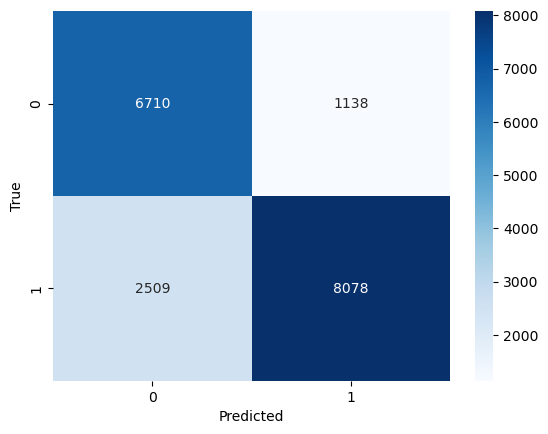

In [ ]:
y_predic_ = model_reservas.predict(x_test_scaled)
y_predic_cat = np.where(y_predic_>0.4,1,0) #Seteamos un corte en los datos para determinar si cancelo o no 

ds_validacion=pd.DataFrame(y_predic_cat,y_test).reset_index() #Armamos un dataset
ds_validacion.columns=['y_pred','y_real'] #Nombramos las columnas

metricas(ds_validacion.y_pred,ds_validacion.y_real) #Dividimos el dataset

## Busqueda de hiper parametros para redes neuronales

Buscamos los hiper params con G.S Kross-V

In [ ]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Definimos la funcion para construir el modelo de la red
def create_model(epochs=10, num_units=64, learning_rate=0.001):
    model = keras.Sequential([
        keras.layers.Dense(num_units, activation='relu', input_shape=(d_in,)),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Creamos un clasificador de keras con stick learn
model = KerasClassifier(build_fn=create_model, batch_size=32, verbose=1)

# Definimos los hiper parametros a buscar
param_grid = {
    'epochs': [100],
    'num_units': [64],
    'learning_rate': [0.001, 0.01, 0.1]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=6)
grid_result = grid_search.fit(x_train_scaled, y_train)

# Obtenemos los mejores hiper parametros para el modelo
best_params = grid_result.best_params_
best_model = grid_result.best_estimator_

# Evaluamos el modelo en el set de validacion
val_accuracy = best_model.score(val_data, val_labels)



In [ ]:
y_pred_nnw = best_model.predict(x_test_scaled)

577/577 [==============================] - 0s 564us/step


In [ ]:
y_pred_nnw

array([[1],
       [0],
       [1],
       ...,
       [1],
       [0],
       [1]])

Graficamos la matriz de confusion y nuestras nuevas metricas

              precision    recall  f1-score   support

           0       0.86      0.83      0.84      9219
           1       0.83      0.86      0.85      9216

    accuracy                           0.85     18435
   macro avg       0.85      0.85      0.85     18435
weighted avg       0.85      0.85      0.85     18435



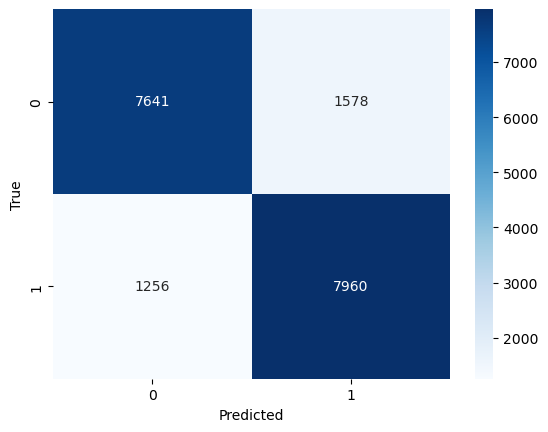

In [ ]:
metricas(y_pred_nnw, y_test)

## Realizamos el import para usar nuestro modelo

In [ ]:
import joblib
joblib.dump(best_model, "neuralnetwork.joblib")

INFO:tensorflow:Assets written to: ram://1a1d36e8-daa5-4977-8bcd-1341c8e913c2/assets


['neuralnetwork.joblib']

In [ ]:
best_model.model.save("test.pkl")

INFO:tensorflow:Assets written to: test.pkl/assets
